In [1]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import os
import matplotlib.pyplot as plt

In [2]:
absolute_path = "C:\\Users\\tykun\\OneDrive\\Documents\\SchoolDocs\\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"  
scripts = "scripts\\"
board_dataframes = "board_dataframes\\"
yearly_interlocks = "yearly_interlocks\\"
final_scripts = "final_scripts\\"
normalized_dataframes = "normalized_dataframes\\"


years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]

In [3]:
board_statistics_path = os.path.join(absolute_path, final_scripts, normalized_dataframes, "normalized_university_board_statistics.csv")
board_statistics_df = pd.read_csv(board_statistics_path)
board_statistics_df["control"] = board_statistics_df["control"].fillna("Unknown")
board_statistics_df["control"] = board_statistics_df["control"].replace("", "Unknown")
board_statistics_df["region"] = board_statistics_df["region"].fillna("Unknown")
board_statistics_df["region"] = board_statistics_df["region"].replace("", "Unknown")
board_statistics_df["duplicate"] = board_statistics_df.duplicated(subset=["Institution", "Year"], keep=False)

# Now, drop duplicates based on the "Institution" and "Year" columns, keeping only the first occurrence.
board_statistics_df = board_statistics_df.drop_duplicates(subset=["Institution", "Year"], keep="first")
def lookup_female_president(row, year):
    """
    Look up the 'female_president' boolean from board_statistics_df for a given row and year.
    
    The function first filters board_statistics_df by the specified year, then attempts to
    match either on 'AffiliationId' (using row['AffiliationId']) or on 'Institution' (using row['Id']).
    It returns the boolean value from the 'female_president' column.
    
    Raises:
        ValueError: If no matching record is found.
    """
    filtered_df = board_statistics_df[board_statistics_df['Year'] == int(year)]
    if row["Id"] in filtered_df["Institution"].values:
        matching_row = filtered_df[filtered_df["Institution"] == row["Id"]].iloc[0]
        if matching_row['female_president'] == True:
            return True
        else:
            return False
    elif row["AffiliationId"] in filtered_df["AffiliationId"].values:
        matching_row = filtered_df[filtered_df["AffiliationId"] == row["AffiliationId"]].iloc[0]
        if matching_row['female_president'] == True:
            return True
        else:
            return False
    return "Unknown"

def lookup_column(row, column_name):
    matching_rows = board_statistics_df[ board_statistics_df['AffiliationId'] == row['AffiliationId'] ]
    if not matching_rows.empty:
        return matching_rows[column_name].mode()[0]
    matching_rows = board_statistics_df[ board_statistics_df['Institution'] == row['Id'] ]
    if not matching_rows.empty:
        return matching_rows[column_name].mode()[0]
    return 'unknown'


In [4]:
# Global edge counter (for unique edge IDs)
edge_id_counter = 1

# Dictionaries/lists to store yearly graphs and summary metrics (all in-memory)
yearly_graphs = {}        # year -> networkx graph (weighted)
yearly_nodes_dfs = {}     # year -> nodes DataFrame
yearly_edges_dfs = {}     # year -> edges DataFrame

yearly_interlock_counts = []     # (Year, total interlocks)
yearly_avg_path_lengths = []     # (Year, avg unweighted path length)
yearly_university_counts = []    # (Year, number of institutions that recorded an interlock)
yearly_density = []              # (Year, network density)
yearly_shortest_path_lengths = []  # (Year, avg unweighted, avg weighted)

# NEW: Global clustering coefficient and number of components arrays.
yearly_global_clustering = []    # (Year, global clustering coefficient)
yearly_num_components = []       # (Year, number of connected components)

for year in years:
    print(f"Processing year: {year}")
    
    # Reinitialize board membership dictionary for this year.
    board_member_dict = defaultdict(set)
    
    file_path = os.path.join(absolute_path, final_scripts, normalized_dataframes, f"{year}_boards_normalized.csv")
    boards_df = pd.read_csv(file_path)

    # ---------------------------
    # Build Mapping: Institution -> Set of Board Member Names (raw)
    # ---------------------------
    institution_to_members = defaultdict(set)
    for _, row in boards_df.iterrows():
        institution_to_members[row['Institution']].add(row['Name'])

    # Compute board sizes per institution (for weighting edges)
    board_sizes = {inst: len(members) for inst, members in institution_to_members.items()}

    edge_accum = {}  # Key: tuple(sorted([inst1, inst2])); Value: dict with edge attributes
    year_nodes_dict = defaultdict(lambda: {'Interlock_Count': 0, 'AffiliationId': None})
    
    # Context for counting interlocks and generating unique edge IDs.
    context_dict = {
        'total_interlocks': 0,
        'edge_id_counter': edge_id_counter
    }
    # To avoid duplicate contributions from the same board member.
    created_interlocks = defaultdict(set)
    
    def process_board_row(row, ctx):
        """
        Process a board row (after cleaning the name) and update interlock counts.
        Skip the row if "vacant" appears in the board member's name.
        """
        if "vacant" in row['Name'].lower():
            return
        name = row['Name']
        institution = row['Institution']
        affiliation_id = row['AffiliationId']
        
        for prev_institution in board_member_dict[name]:
            if prev_institution == institution:
                continue

            pair = tuple(sorted([prev_institution, institution]))
            if pair in created_interlocks[name]:
                continue
            created_interlocks[name].add(pair)

            # Weight of edges: each shared board member contributes 1.
            w = 1

            if pair in edge_accum:
                edge_accum[pair]['Weight'] += w
            else:
                edge_id = f"e{ctx['edge_id_counter']}"
                ctx['edge_id_counter'] += 1
                edge_accum[pair] = {
                    'Id': edge_id,
                    'Source': pair[0],
                    'Target': pair[1],
                    'Type': 'Undirected',
                    'Weight': w,
                    'Year': year
                }
            ctx['total_interlocks'] += 1
            # Update node interlock counts.
            year_nodes_dict[prev_institution]['Interlock_Count'] += w
            year_nodes_dict[institution]['Interlock_Count'] += w
        
        board_member_dict[name].add(institution)
        if year_nodes_dict[institution]['AffiliationId'] is None:
            year_nodes_dict[institution]['AffiliationId'] = affiliation_id

    for _, row in boards_df.iterrows():
        process_board_row(row, context_dict)

    total_interlocks = context_dict['total_interlocks']
    edge_id_counter = context_dict['edge_id_counter']

    # Recalculate each edge's weight as the ratio of shared board members to total unique board members.
    for pair, edge in edge_accum.items():
        shared_members = edge['Weight']  # This is the count of shared board members.
        total_unique = board_sizes.get(pair[0], 0) + board_sizes.get(pair[1], 0) - shared_members
        edge['Weight'] = shared_members / total_unique if total_unique > 0 else 0

    # Create a nodes DataFrame (in-memory only).
    nodes_df = pd.DataFrame(
        [(inst, data['Interlock_Count'], data['AffiliationId'])
         for inst, data in year_nodes_dict.items()],
        columns=['Id', 'Interlock_Count', 'AffiliationId']
    )
    # Ensure "control" column is set to "Public" if empty or NaN

    nodes_df['Label'] = nodes_df['Id']
    nodes_df['female_president'] = nodes_df.apply(lambda row: lookup_female_president(row, year), axis=1)
    nodes_df['control'] = nodes_df.apply(lambda row: lookup_column(row, 'control'), axis=1)
    nodes_df['region'] = nodes_df.apply(lambda row: lookup_column(row, 'region'), axis=1)
    nodes_df = nodes_df[['Id', 'Label', 'Interlock_Count', 'AffiliationId',
                         'female_president', 'control', 'region']]
    
    # ---------------------------
    # Remove singleton nodes (nodes with no interlocks)
    # ---------------------------
    nodes_df = nodes_df[nodes_df["Interlock_Count"] > 0].copy()
    
    # Create an edges DataFrame (in-memory only).
    if edge_accum:
        edges_df = pd.DataFrame(list(edge_accum.values()))
    else:
        edges_df = pd.DataFrame()
    if not edges_df.empty:
        edges_df = edges_df[['Id', 'Source', 'Target', 'Type', 'Weight', 'Year']]
    
    # ---------------------------
    # Build the Weighted Graph for This Year (only with nodes that recorded an interlock)
    # ---------------------------
    import networkx as nx
    G = nx.Graph()
    for _, node_row in nodes_df.iterrows():
        G.add_node(
            node_row["Id"],
            AffiliationId=node_row["AffiliationId"],
            Label=node_row["Label"],
            Interlock_Count=node_row["Interlock_Count"],
            female_president=node_row["female_president"],
            control=node_row["control"],
            region=node_row["region"]
        )
    # Only add edges whose both endpoints are in the filtered nodes_df.
    valid_nodes = set(nodes_df["Id"].unique())
    for _, edge_row in edges_df.iterrows():
        if edge_row["Source"] in valid_nodes and edge_row["Target"] in valid_nodes:
            G.add_edge(edge_row["Source"], edge_row["Target"], weight=edge_row.get("Weight", 1))
    
    # Store yearly results in memory.
    yearly_graphs[year] = G
    yearly_nodes_dfs[year] = nodes_df
    yearly_edges_dfs[year] = edges_df

    # ---------------------------
    # Compute Summary Metrics for This Year (using only non-singleton nodes)
    # ---------------------------
    # Count only nodes that participate in at least one interlock.
    num_interlocked_institutions = sum(1 for n in G.nodes() if G.degree(n) > 0)
    dens = nx.density(G)
    
    # Create an unweighted copy of G (i.e. set every edge weight to 1)
    G_unweighted = nx.Graph()
    G_unweighted.add_nodes_from(G.nodes(data=True))
    for u, v in G.edges():
        G_unweighted.add_edge(u, v, weight=1)
    
    # Compute average shortest path lengths on separate graphs.
    if nx.is_connected(G_unweighted):
        avg_path_unweighted = nx.average_shortest_path_length(G_unweighted)
    else:
        if G_unweighted.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G_unweighted), key=len)
            subG_unweighted = G_unweighted.subgraph(largest_cc)
            avg_path_unweighted = nx.average_shortest_path_length(subG_unweighted)
        else:
            avg_path_unweighted = float('nan')
    
    if nx.is_connected(G):
        avg_path_weighted = nx.average_shortest_path_length(G, weight="weight")
    else:
        if G.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G), key=len)
            subG = G.subgraph(largest_cc)
            avg_path_weighted = nx.average_shortest_path_length(subG, weight="weight")
        else:
            avg_path_weighted = float('nan')
    
    yearly_interlock_counts.append((int(year), total_interlocks))
    # Append the number of institutions that actually recorded an interlock.
    yearly_university_counts.append((int(year), num_interlocked_institutions))
    yearly_density.append((int(year), dens))
    yearly_avg_path_lengths.append((int(year), avg_path_unweighted))
    yearly_shortest_path_lengths.append((int(year), avg_path_unweighted, avg_path_weighted))
    
    # NEW: Compute global clustering coefficient and number of connected components.
    global_clust = nx.transitivity(G)
    num_components = nx.number_connected_components(G)
    yearly_global_clustering.append((int(year), global_clust))
    yearly_num_components.append((int(year), num_components))

# =============================================================================
# Create Global Nodes and Edges DataFrames (all interlocks over time)
# =============================================================================
global_nodes_df = pd.concat(list(yearly_nodes_dfs.values()), ignore_index=True)
global_edges_df = pd.concat(list(yearly_edges_dfs.values()), ignore_index=True)

global_nodes_path = os.path.join(absolute_path, final_scripts, normalized_dataframes, "all_interlocks_nodes.csv")
global_edges_path = os.path.join(absolute_path, final_scripts, normalized_dataframes, "all_interlocks_edges.csv")

global_nodes_df.to_csv(global_nodes_path, index=False)
global_edges_df.to_csv(global_edges_path, index=False)

print(f"Global nodes CSV written to: {global_nodes_path}")
print(f"Global edges CSV written to: {global_edges_path}")


Processing year: 1999
Processing year: 2000
Processing year: 2005
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2011
Processing year: 2013
Processing year: 2018
Global nodes CSV written to: C:\Users\tykun\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\normalized_dataframes\all_interlocks_nodes.csv
Global edges CSV written to: C:\Users\tykun\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\normalized_dataframes\all_interlocks_edges.csv


In [5]:
# =============================================================================
# Add Network Statistics into board_statistics_df
# =============================================================================

# --- Compute centrality measures for each year's graph and update the yearly nodes DataFrames ---
for year in years:
    # Retrieve the graph and corresponding nodes DataFrame for the year.
    G = yearly_graphs[year]
    nodes_df = yearly_nodes_dfs[year].copy()
    
    # Compute centrality measures on G.
    betweenness = nx.betweenness_centrality(G, weight="weight")
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000, weight="weight")
    degree_dict = dict(G.degree())
    clustering = nx.clustering(G, weight="weight")
    
    # Add the centrality measures as new columns.
    nodes_df["betweenness"] = nodes_df["Id"].map(betweenness)
    nodes_df["closeness"] = nodes_df["Id"].map(closeness)
    nodes_df["eigenvector"] = nodes_df["Id"].map(eigenvector)
    nodes_df["degree"] = nodes_df["Id"].map(degree_dict)
    nodes_df["clustering"] = nodes_df["Id"].map(clustering)
    
    # Make sure there is a 'Year' column (as string) in each nodes DataFrame.
    if 'Year' not in nodes_df.columns:
        nodes_df['Year'] = str(year)
    else:
        nodes_df['Year'] = nodes_df['Year'].astype(str)
    
    # Update the yearly nodes DataFrame.
    yearly_nodes_dfs[year] = nodes_df

# --- Create a global nodes DataFrame that spans all years ---
global_nodes_df = pd.concat(list(yearly_nodes_dfs.values()), ignore_index=True)

# Ensure the 'Year' column in global_nodes_df is of type string.
global_nodes_df['Year'] = global_nodes_df['Year'].astype(str)

# --- Load the existing board statistics DataFrame ---
board_statistics_path = os.path.join(absolute_path, final_scripts, normalized_dataframes, "normalized_university_board_statistics.csv")
board_statistics_df = pd.read_csv(board_statistics_path)

# Ensure the 'Year' column in board_statistics_df is also of type string.
board_statistics_df['Year'] = board_statistics_df['Year'].astype(str)

# --- Merge network statistics from global_nodes_df into board_statistics_df ---
merged_df = board_statistics_df.merge(
    global_nodes_df[["Year", "AffiliationId", "betweenness", "closeness", "eigenvector", "degree", "clustering"]],
    on=["Year", "AffiliationId"],
    how="left",
    suffixes=("", "_new")
)

# If the merged DataFrame has duplicate centrality columns (e.g. 'betweenness_new'), replace the originals.
for col in ["betweenness", "closeness", "eigenvector", "degree", "clustering"]:
    if f"{col}_new" in merged_df.columns:
        merged_df[col] = merged_df[f"{col}_new"]
        merged_df.drop(columns=[f"{col}_new"], inplace=True)

# Fill missing centrality values with zeros.
centrality_columns = ["betweenness", "closeness", "eigenvector", "degree", "clustering"]
merged_df[centrality_columns] = merged_df[centrality_columns].fillna(0)

# --- Write the updated board statistics back to CSV ---
updated_stats_path = os.path.join(absolute_path, final_scripts, normalized_dataframes, "normalized_university_board_statistics.csv")
merged_df.to_csv(updated_stats_path, index=False)
print(f"Updated board_statistics_df with network statistics written to: {updated_stats_path}")


Updated board_statistics_df with network statistics written to: C:\Users\tykun\OneDrive\Documents\SchoolDocs\VSCodeProjects\connectedData\board_analysis\final_scripts\normalized_dataframes\normalized_university_board_statistics.csv


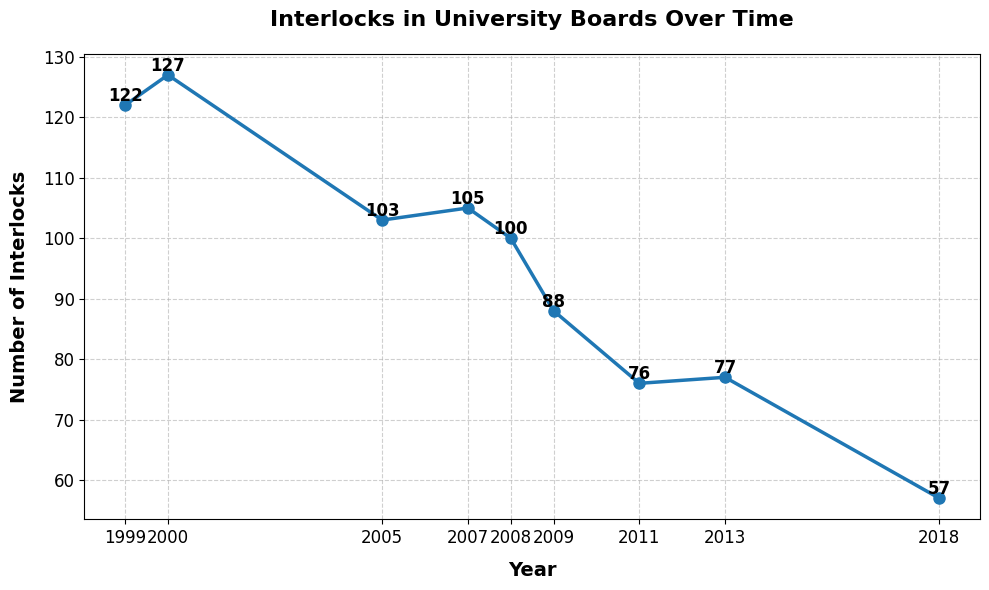

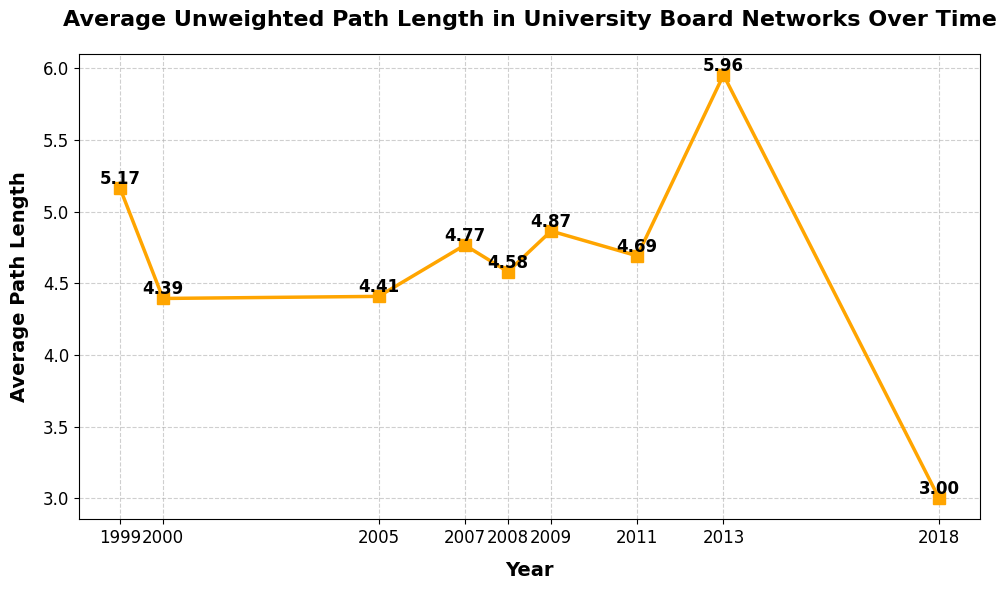

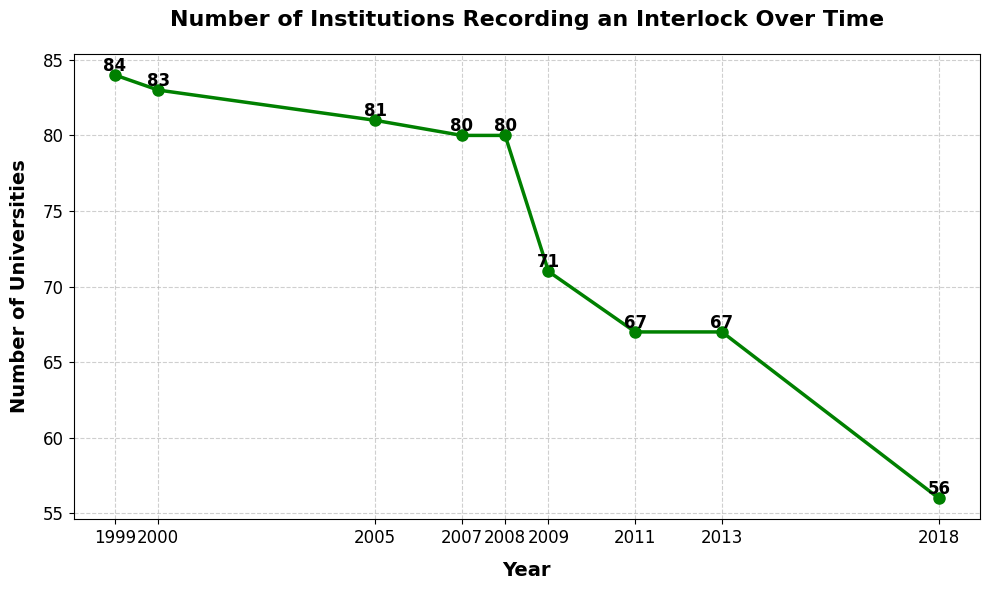

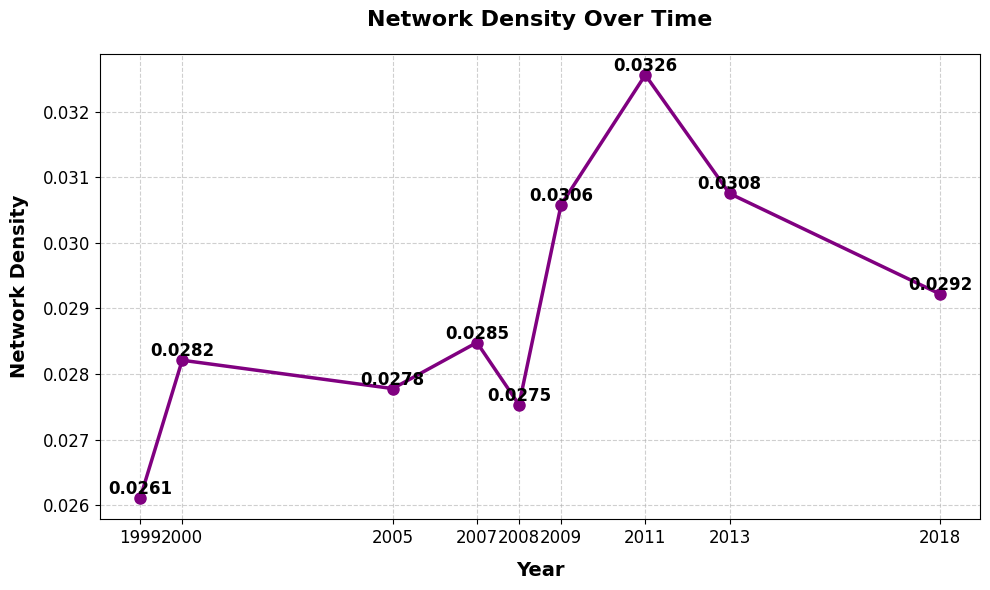

C:\Users\tykun\AppData\Local\Temp\ipykernel_16392\411936357.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


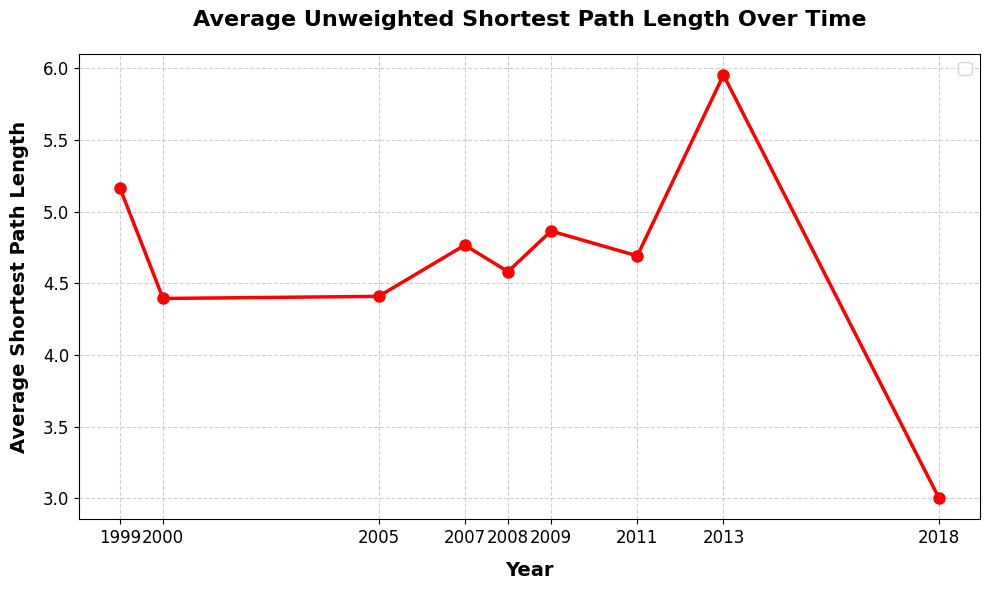

C:\Users\tykun\AppData\Local\Temp\ipykernel_16392\411936357.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


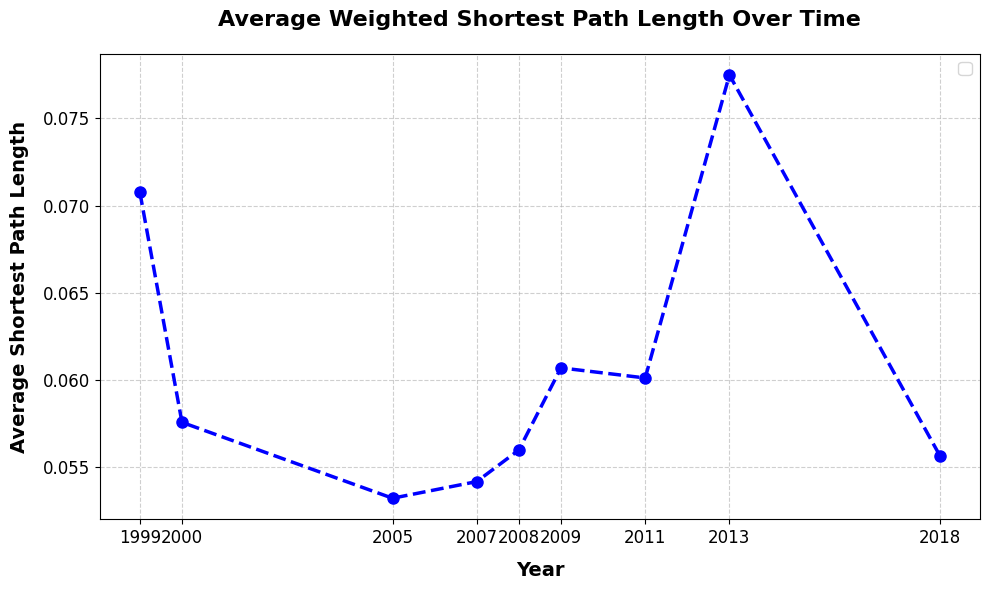

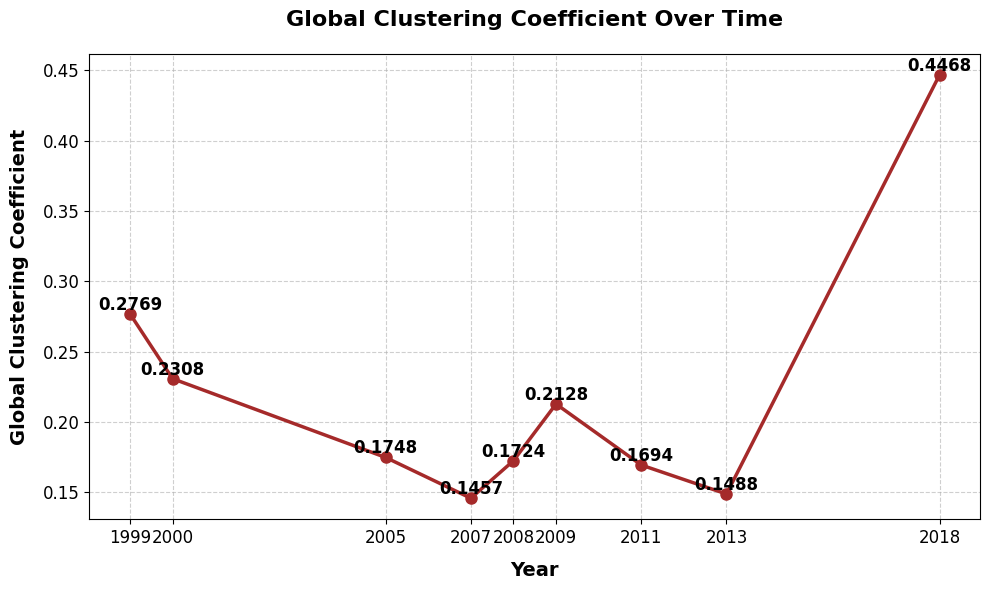

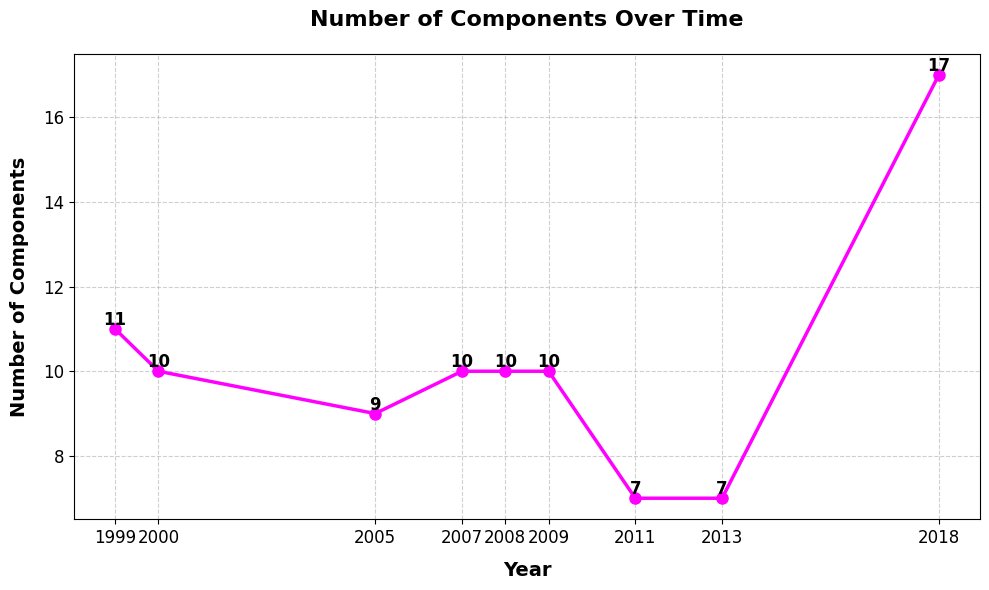

In [6]:
# 1) Plot Total Interlocks Over Time
df_interlocks = pd.DataFrame(yearly_interlock_counts, columns=['Year', 'TotalInterlocks'])
df_interlocks.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_interlocks['Year'], df_interlocks['TotalInterlocks'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='#1f77b4')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Interlocks', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Interlocks in University Boards Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_interlocks['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_interlocks['Year'], df_interlocks['TotalInterlocks']):
    plt.text(x, y, f'{y}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 2) Plot Average Path Length Over Time (Unweighted)
df_avg_path = pd.DataFrame(yearly_avg_path_lengths, columns=['Year', 'AvgPathLength'])
df_avg_path.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_avg_path['Year'], df_avg_path['AvgPathLength'], marker='s', linestyle='-', linewidth=2.5, markersize=8, color='orange')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Path Length', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Average Unweighted Path Length in University Board Networks Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_avg_path['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_avg_path['Year'], df_avg_path['AvgPathLength']):
    plt.text(x, y, f'{y:.2f}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 3) Plot Number of Universities Over Time (institutions that recorded at least one interlock)
df_universities = pd.DataFrame(yearly_university_counts, columns=['Year', 'NumUniversities'])
df_universities.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_universities['Year'], df_universities['NumUniversities'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='green')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Universities', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Number of Institutions Recording an Interlock Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_universities['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_universities['Year'], df_universities['NumUniversities']):
    plt.text(x, y, f'{y}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 4) Plot Network Density Over Time
df_density = pd.DataFrame(yearly_density, columns=['Year', 'Density'])
df_density.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_density['Year'], df_density['Density'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='purple')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Network Density', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Network Density Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_density['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_density['Year'], df_density['Density']):
    plt.text(x, y, f'{y:.4f}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 5) Plot Average Shortest Path Length Over Time (Separate Unweighted & Weighted)
df_shortest_paths = pd.DataFrame(yearly_shortest_path_lengths, columns=['Year', 'AvgPathLength', 'AvgWeightedPathLength'])
df_shortest_paths.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_shortest_paths['Year'], df_shortest_paths['AvgPathLength'], marker='o', linestyle='-', linewidth=2.5, markersize=8, color='red')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Shortest Path Length', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Average Unweighted Shortest Path Length Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_shortest_paths['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_shortest_paths['Year'], df_shortest_paths['AvgWeightedPathLength'], marker='o', linestyle='--', linewidth=2.5, markersize=8, color='blue')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Average Shortest Path Length', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Average Weighted Shortest Path Length Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_shortest_paths['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 6) Plot Global Clustering Coefficient Over Time
df_global_clustering = pd.DataFrame(yearly_global_clustering, columns=['Year', 'GlobalClustering'])
df_global_clustering.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_global_clustering['Year'], df_global_clustering['GlobalClustering'], marker='o', linestyle='-', 
         linewidth=2.5, markersize=8, color='brown')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Global Clustering Coefficient', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Global Clustering Coefficient Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_global_clustering['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_global_clustering['Year'], df_global_clustering['GlobalClustering']):
    plt.text(x, y, f'{y:.4f}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 7) Plot Number of Components Over Time
df_components = pd.DataFrame(yearly_num_components, columns=['Year', 'NumComponents'])
df_components.sort_values('Year', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(df_components['Year'], df_components['NumComponents'], marker='o', linestyle='-', 
         linewidth=2.5, markersize=8, color='magenta')
plt.xlabel('Year', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Number of Components', fontsize=14, fontweight='bold', labelpad=10)
plt.title('Number of Components Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xticks(df_components['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for x, y in zip(df_components['Year'], df_components['NumComponents']):
    plt.text(x, y, f'{y}', fontsize=12, ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()
